# Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
from numpy import nan
from bs4 import BeautifulSoup    
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from math import sqrt
from sklearn.model_selection import train_test_split
from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, LabelBinarizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans

import logging
from optparse import OptionParser
import sys
from time import time
from sklearn.naive_bayes import MultinomialNB
from yellowbrick.text import DispersionPlot
from yellowbrick.text import TSNEVisualizer
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
import numpy as np
import pandas as pd

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, SpatialDropout1D, Flatten
from keras.layers import LSTM
from sklearn.metrics import balanced_accuracy_score, precision_score, roc_auc_score, roc_curve, auc
from pandas.tools.plotting import scatter_matrix
from pandas.tools.plotting import andrews_curves
from sklearn import linear_model
import pickle
from keras.models import load_model
from gensim.models import word2vec

[nltk_data] Downloading package stopwords to /home/talha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


# Reading Data

In [16]:
train_data = pd.read_csv("train.tsv", sep="\t")

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [4]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


# Adding a new column for counting label instances

In [17]:
Sentiment_words=[]
for row in train_data['Sentiment']:
    if row ==0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('neutral')
    elif row == 2:
        Sentiment_words.append('somewhat negative')
    elif row == 3:
        Sentiment_words.append('somewhat positive')
    elif row == 4:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
train_data['Sentiment_words'] = Sentiment_words

# Counting label categories

In [4]:
word_count=pd.value_counts(train_data['Sentiment_words'].values, sort=False)
word_count

positive              9206
somewhat negative    79582
somewhat positive    32927
negative              7072
neutral              27273
dtype: int64

# Visual Representation of label counts

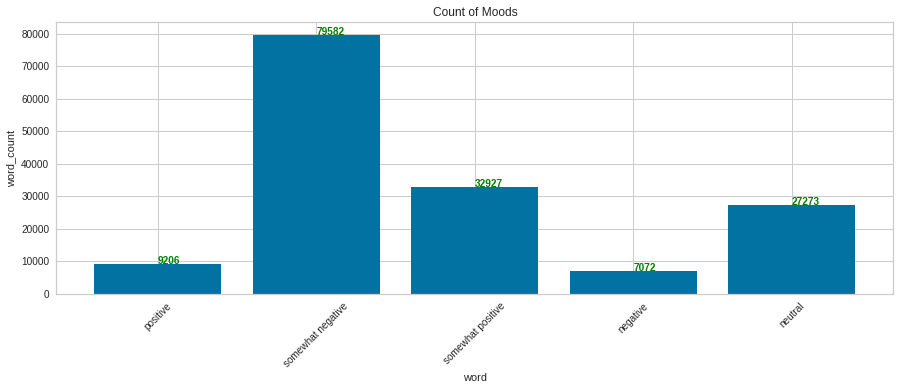

In [5]:
Index = [1,2,3,4,5]
plt.figure(figsize=(15,5))
plt.bar(Index,word_count,color = 'blue')
plt.xticks(Index,['positive','somewhat negative','somewhat positive','negative','neutral'],rotation=45)
plt.ylabel('word_count')
plt.xlabel('word')
plt.title('Count of Moods')
plt.bar(Index, word_count)
for a,b in zip(Index, word_count):
    plt.text(a, b, str(b) ,color='green', fontweight='bold')

# Function to remove stop words from a phrase

In [18]:
def review_to_words(raw_review): 
    review =raw_review
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = review.lower()
    review = review.split()
    lemmatizer = WordNetLemmatizer()
    review = [lemmatizer.lemmatize(w) for w in review if not w in set(stopwords.words('english'))]
    return (' '.join(review))

# Removing stop words from training data

In [19]:
cleaned_train_phrases= []
for i in range(0, 156060):
    cleaned_train_phrases.append(review_to_words(train_data['Phrase'][i]))

# Adding cleaned phrases to training data

In [20]:
train_data['Cleaned_Phrase']=cleaned_train_phrases

# Dropping the old phrase column

In [21]:
train_data.drop(['Phrase'],axis=1,inplace=True)

# Train data with cleaned phrases

In [8]:
train_data.head()

,PhraseId,SentenceId,Sentiment,Sentiment_words,Cleaned_Phrase
0,1,1,1,neutral,series escapade demonstrating adage good goose...
1,2,1,2,somewhat negative,series escapade demonstrating adage good goose
2,3,1,2,somewhat negative,series
3,4,1,2,somewhat negative,
4,5,1,2,somewhat negative,series


# Class Distribution  Visualization using t-SNE

In [9]:

tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(train_data['Cleaned_Phrase'])
labels = train_data.iloc[:, 2].values

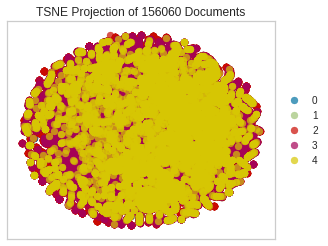

In [13]:
tsne = TSNEVisualizer()
tsne.fit(docs, labels)
tsne.poof()

# K Means

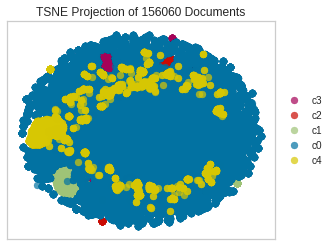

In [14]:
clusters = KMeans(n_clusters=5)
clusters.fit(docs)

tsne = TSNEVisualizer()
tsne.fit(docs, ["c{}".format(c) for c in clusters.labels_])
tsne.poof()

# Top 10 terms per cluster

In [16]:
print("Top terms per cluster:")
order_centroids = clusters.cluster_centers_.argsort()[:, ::-1]

terms = tfidf.get_feature_names()
for i in range(5):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Top terms per cluster:
Cluster 0: one character time like good comedy rrb life much way
Cluster 1: movie one bad make like good made action year time
Cluster 2: work well movie film one piece best previous still may
Cluster 3: story love tell true one character compelling little film give
Cluster 4: film one good like first best make action seen well


# Top 10 words in the dataset

In [9]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 
sp=train_data['Cleaned_Phrase']
sp_words = vectorizer.fit_transform(sp)
sp_words = sp_words.toarray()
sp= vectorizer.get_feature_names()
dist = np.sum(sp_words, axis=0)
sp_new= pd.DataFrame(dist)
sp_new.columns=['word_count']
sp_new['word'] = pd.Series(sp, index=sp_new.index)
sp_new1=sp_new[['word','word_count']]
sp_new1.head()
top_30_words=sp_new1.sort_values(['word_count'],ascending=[0])
top_30_words.head(10)

,word,word_count
666,film,7712
1136,movie,7586
1208,one,3958
1007,like,3211
249,character,2900
1683,story,2850
1797,time,2472
1473,rrb,2438
1051,make,2433
774,good,2304


# Dispersion Plot of Top 10 words in the dataset

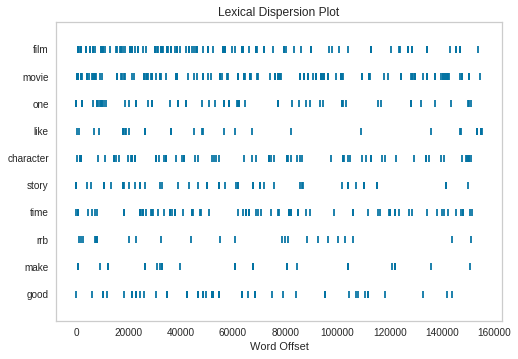

In [38]:
visualizer = DispersionPlot(top_30_words['word'][:10])
visualizer.fit(train_data['Cleaned_Phrase'])
visualizer.poof()

# Visualizing the word cloud

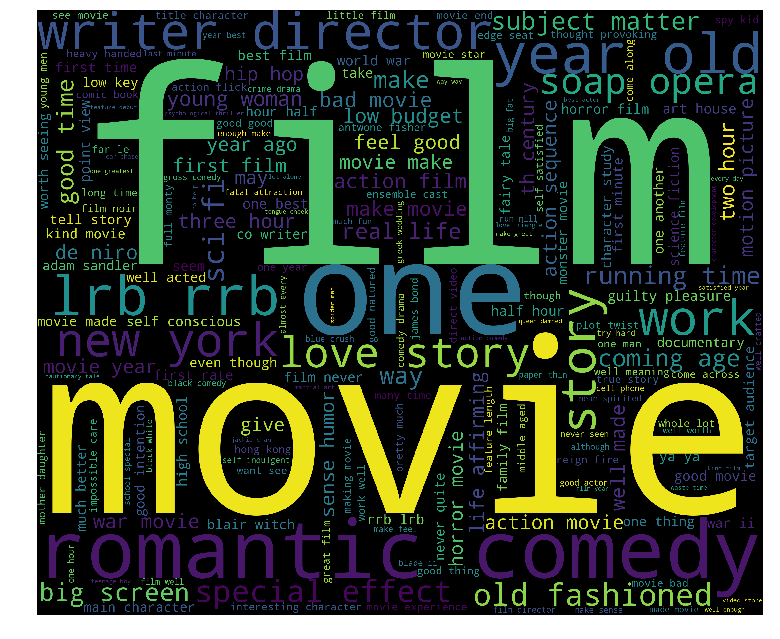

In [39]:
words = ' '.join(train_data['Cleaned_Phrase'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(words)
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Selecting positive examples from the dataset

In [11]:
positive_examples=train_data[train_data['Sentiment_words']==('positive')]

# Extracting words from positive examples

In [12]:
positive_words = ' '.join(positive_examples['Cleaned_Phrase'])

# Creating a positive word cloud

In [15]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(positive_words)

# Visualizing positive word cloud

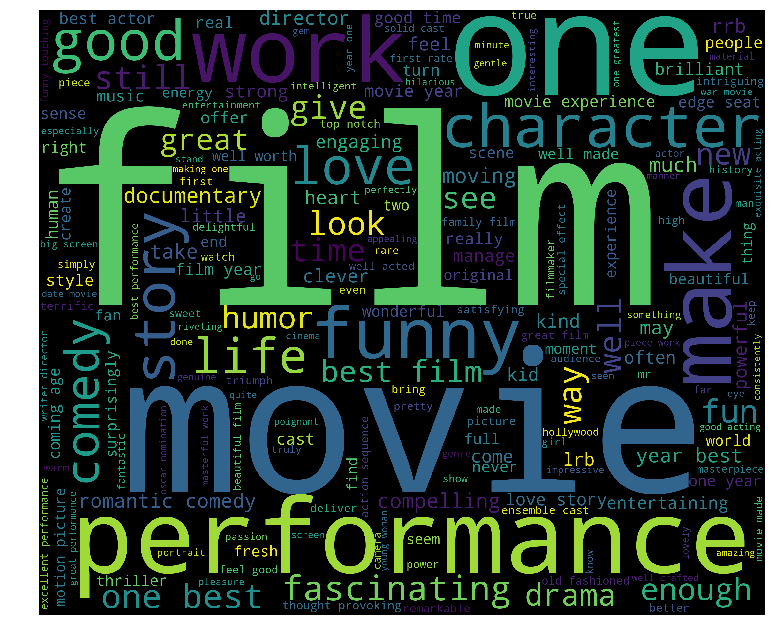

In [16]:
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Visualizing negative word cloud

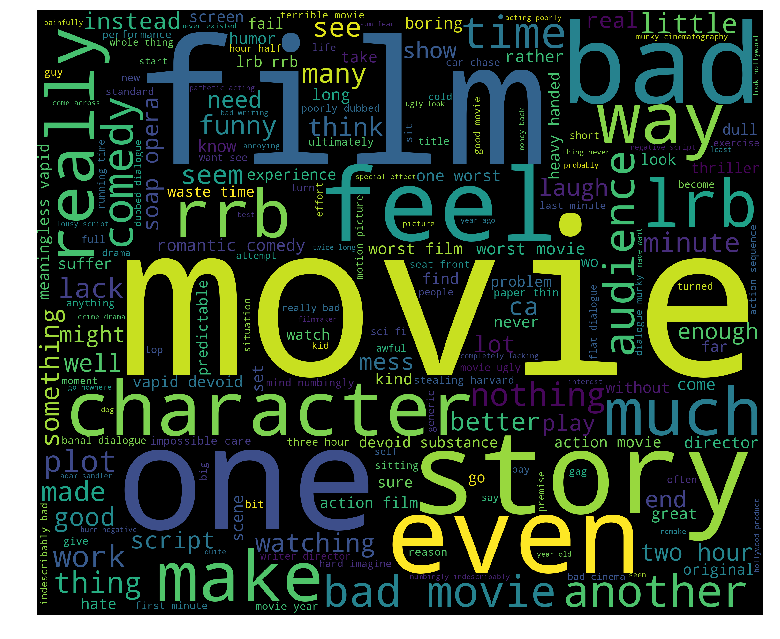

In [16]:
negative_examples=train_data[train_data['Sentiment_words']==('negative')]
negative_words = ' '.join(negative_examples['Cleaned_Phrase'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(negative_words)
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Visualizing neutral word cloud

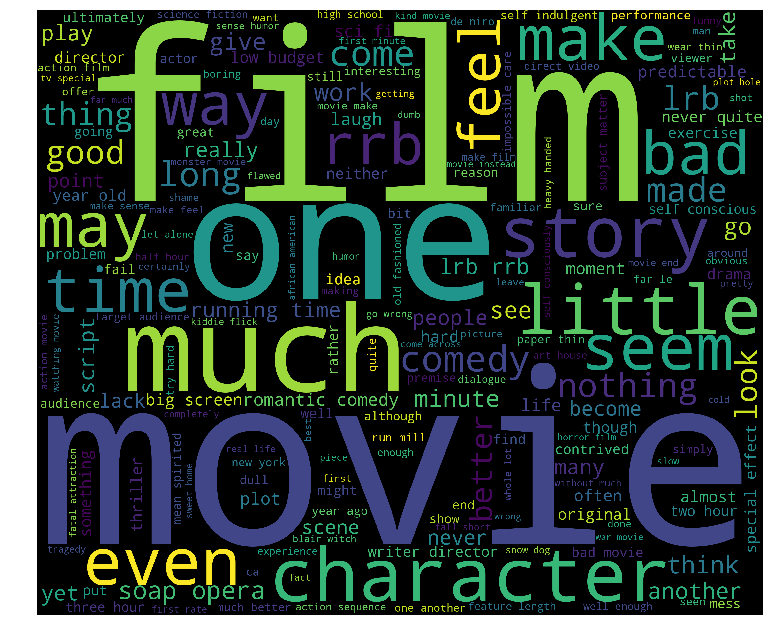

In [17]:
neutral_examples=train_data[train_data['Sentiment_words']==('neutral')]
neutral_words = ' '.join(neutral_examples['Cleaned_Phrase'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(neutral_words)
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Visualizing somewhat positive word cloud

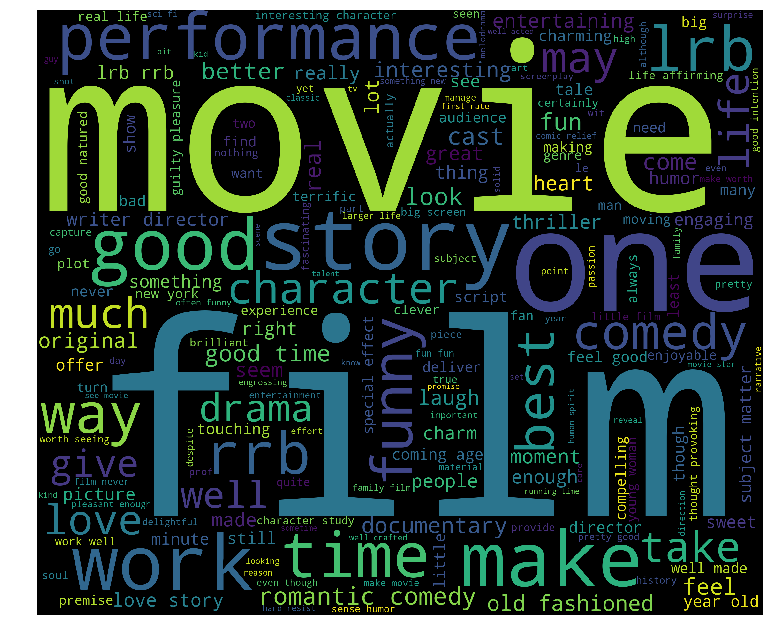

In [18]:
some_what_positive_examples=train_data[train_data['Sentiment_words']==('somewhat positive')]
some_what_positive_words = ' '.join(some_what_positive_examples['Cleaned_Phrase'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(some_what_positive_words)
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Visualizing somewhat negative word cloud

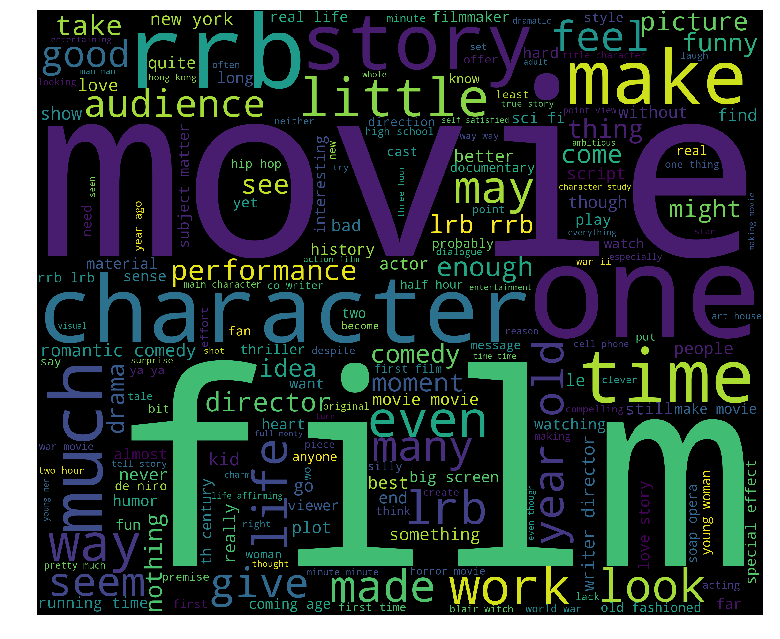

In [19]:
some_what_negative_examples=train_data[train_data['Sentiment_words']==('somewhat negative')]
some_what_negative_words = ' '.join(some_what_negative_examples['Cleaned_Phrase'])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(some_what_negative_words)
plt.figure(1,figsize=(13, 13))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Top 10 positive words

In [13]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 
pos=positive_examples['Cleaned_Phrase']
pos_words = vectorizer.fit_transform(pos)
pos_words = pos_words.toarray()
pos= vectorizer.get_feature_names()
dist = np.sum(pos_words, axis=0)
postive_new= pd.DataFrame(dist)
postive_new.columns=['word_count']
postive_new['word'] = pd.Series(pos, index=postive_new.index)
postive_new1=postive_new[['word','word_count']]
postive_new1.head()
top_30_pos_words=postive_new1.sort_values(['word_count'],ascending=[0])
top_30_pos_words.head(10)

,word,word_count
652,film,1104
1149,movie,757
1223,one,517
1280,performance,472
161,best,394
715,funny,347
760,good,339
1933,well,317
1672,story,280
1990,year,275


# Top 10 negative words

In [20]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 
neg=negative_examples['Cleaned_Phrase']
neg_words = vectorizer.fit_transform(neg)
neg_words = neg_words.toarray()
neg= vectorizer.get_feature_names()
dist = np.sum(neg_words, axis=0)
negative_new= pd.DataFrame(dist)
negative_new.columns=['word_count']
negative_new['word'] = pd.Series(neg, index=negative_new.index)
negative_new1=negative_new[['word','word_count']]
negative_new1.head()
top_30_neg_words=negative_new1.sort_values(['word_count'],ascending=[0])
top_30_neg_words.head(10)

,word,word_count
1079,movie,862
561,film,542
105,bad,450
932,like,332
1144,one,304
216,character,227
1048,minute,224
1763,time,193
268,comedy,183
986,make,183


# Top 10 neutral words

In [21]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 
neu=neutral_examples['Cleaned_Phrase']
neu_words = vectorizer.fit_transform(neu)
neu_words = neu_words.toarray()
neu= vectorizer.get_feature_names()
dist = np.sum(neu_words, axis=0)
neutral_new= pd.DataFrame(dist)
neutral_new.columns=['word_count']
neutral_new['word'] = pd.Series(neu, index=neutral_new.index)
neutral_new1=neutral_new[['word','word_count']]
neutral_new1.head()
top_30_neu_words=neutral_new1.sort_values(['word_count'],ascending=[0])
top_30_neu_words.head(10)

,word,word_count
1121,movie,1703
643,film,1440
989,like,942
1192,one,825
227,character,670
1125,much,595
1669,story,578
1795,time,526
1443,rrb,498
1001,little,492


# Top 10 somewhat negative words

In [22]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 
sn=some_what_negative_examples['Cleaned_Phrase']
sn_words = vectorizer.fit_transform(sn)
sn_words = sn_words.toarray()
sn= vectorizer.get_feature_names()
dist = np.sum(sn_words, axis=0)
sn_new= pd.DataFrame(dist)
sn_new.columns=['word_count']
sn_new['word'] = pd.Series(sn, index=sn_new.index)
sn_new1=sn_new[['word','word_count']]
sn_new1.head()
top_30_sn_words=sn_new1.sort_values(['word_count'],ascending=[0])
top_30_sn_words.head(10)

,word,word_count
1133,movie,2625
643,film,2563
1203,one,1423
991,like,1176
1466,rrb,1112
1686,story,1089
257,character,1032
1805,time,977
987,life,952
1024,lrb,878


# Top 10 somewhat positive words

In [23]:
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 2000) 
sp=some_what_positive_examples['Cleaned_Phrase']
sp_words = vectorizer.fit_transform(sp)
sp_words = sp_words.toarray()
sp= vectorizer.get_feature_names()
dist = np.sum(sp_words, axis=0)
sp_new= pd.DataFrame(dist)
sp_new.columns=['word_count']
sp_new['word'] = pd.Series(sp, index=sp_new.index)
sp_new1=sp_new[['word','word_count']]
sp_new1.head()
top_30_sp_words=sp_new1.sort_values(['word_count'],ascending=[0])
top_30_sp_words.head(10)

,word,word_count
663,film,2063
1138,movie,1639
765,good,991
1214,one,889
252,character,756
1059,make,752
1676,story,739
1012,life,645
726,funny,639
1017,like,610


# Top 5 words in each category

In [26]:
top_30_pos_words.head(5), top_30_neg_words.head(5), top_30_neu_words.head(5), top_30_sp_words.head(5) , top_30_sn_words.head(5)

(             word  word_count
 652          film        1104
 1149        movie         757
 1223          one         517
 1280  performance         472
 161          best         394,        word  word_count
 1079  movie         862
 561    film         542
 105     bad         450
 932    like         332
 1144    one         304,            word  word_count
 1121      movie        1703
 643        film        1440
 989        like         942
 1192        one         825
 227   character         670,            word  word_count
 663        film        2063
 1138      movie        1639
 765        good         991
 1214        one         889
 252   character         756,        word  word_count
 1133  movie        2625
 643    film        2563
 1203    one        1423
 991    like        1176
 1466    rrb        1112)

# Converting text to token counts matrix using CountVectorizer  

In [10]:
cv = CountVectorizer(max_features = 2000)
x = cv.fit_transform(cleaned_train_phrases).toarray()
y = train_data.iloc[:, 2].values

# Data Dimensions

In [17]:
x.shape, y.shape

((156060, 2000), (156060,))

# Splitting train and test data

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

# Multinomial Naive Bayes

In [43]:
classifier = MultinomialNB()
classifier.fit(x_train, y_train)

filename = 'nb_1_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

y_pred = classifier.predict(x_test)
print ("Accuracy : ",sum(y_pred == y_test)/float(len(y_pred)))

Accuracy :  0.591674142424


# Loading Model and predicting results

In [44]:
loaded_model = pickle.load(open('nb_1_model.sav', 'rb'))

cv = CountVectorizer(max_features = 2000)
docs = cv.fit_transform(cleaned_train_phrases).toarray()
labels = train_data.iloc[:, 2].values

result = loaded_model.predict(docs)

a_sentiment = ["" for x in range(np.shape(result)[0])]
p_sentiment = ["" for x in range(np.shape(result)[0])]

for i in range(np.shape(result)[0]):
    if labels[i] == 0:
        a_sentiment[i] = "negtive"
    if labels[i] == 1:
        a_sentiment[i] = "somewhat negtive"
    if labels[i] == 2:
        a_sentiment[i] = "neutral"    
    if labels[i] == 3:
        a_sentiment[i] = "somewhat positive"
    if labels[i] == 4:
        a_sentiment[i] = "positive" 

for i in range(np.shape(result)[0]):
    if result[i] == 0:
        p_sentiment[i] = "negtive"
    if result[i] == 1:
        p_sentiment[i] = "somewhat negtive"
    if result[i] == 2:
        p_sentiment[i] = "neutral"    
    if result[i] == 3:
        p_sentiment[i] = "somewhat positive"
    if result[i] == 4:
        p_sentiment[i] = "positive" 
        
print (train_data['Cleaned_Phrase'][-55:-50])
print (p_sentiment[-55:-50])
print (a_sentiment[-55:-50])

156005                                    capable clayburgh
156006                                    capable clayburgh
156007    really great job anchoring character emotional...
156008    great job anchoring character emotional realit...
156009    great job anchoring character emotional realit...
Name: Cleaned_Phrase, dtype: object
['neutral', 'neutral', 'somewhat positive', 'somewhat positive', 'somewhat positive']
['somewhat positive', 'somewhat negtive', 'positive', 'somewhat positive', 'somewhat positive']


# Balanced Accuracy Rate

In [28]:
print ("BAC : ",balanced_accuracy_score(y_test, y_pred))

BAC :  0.364360124998


# Area Under the Receiver Operating Characteristic Curve

In [63]:
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(y_pred)    

In [64]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute weighted-average ROC curve and ROC area
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

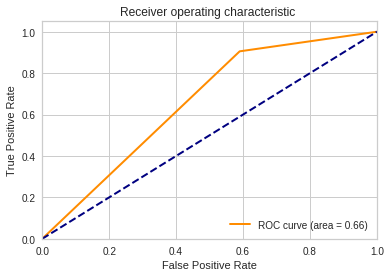

In [66]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

# Converting text to token counts matrix using TfidfVectorizer

In [8]:
tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(train_data['Cleaned_Phrase'])
labels = train_data.iloc[:, 2].values

# Data Dimensions

In [22]:
docs.shape, labels.shape

((156060, 13606), (156060,))

# Splitting train and test data

In [9]:
x_train, x_test, y_train, y_test = train_test_split(docs, labels, test_size = 0.30, random_state = 0)

# Multinomial Naive Bayes

In [10]:
classifier = MultinomialNB()
classifier.fit(x_train, y_train)

filename = 'nb_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

y_pred = classifier.predict(x_test)
print ("Accuracy : ",sum(y_pred == y_test)/float(len(y_pred)))

Accuracy :  0.588512965099


# Loading Model and predicting results

In [37]:
loaded_model = pickle.load(open('nb_model.sav', 'rb'))

tfidf  = TfidfVectorizer()

docs   = tfidf.fit_transform(train_data['Cleaned_Phrase'])
labels = train_data.iloc[:, 2].values

result = loaded_model.predict(docs)

a_sentiment = ["" for x in range(np.shape(result)[0])]
p_sentiment = ["" for x in range(np.shape(result)[0])]

for i in range(np.shape(result)[0]):
    if labels[i] == 0:
        a_sentiment[i] = "negtive"
    if labels[i] == 1:
        a_sentiment[i] = "somewhat negtive"
    if labels[i] == 2:
        a_sentiment[i] = "neutral"    
    if labels[i] == 3:
        a_sentiment[i] = "somewhat positive"
    if labels[i] == 4:
        a_sentiment[i] = "positive" 

for i in range(np.shape(result)[0]):
    if result[i] == 0:
        p_sentiment[i] = "negtive"
    if result[i] == 1:
        p_sentiment[i] = "somewhat negtive"
    if result[i] == 2:
        p_sentiment[i] = "neutral"    
    if result[i] == 3:
        p_sentiment[i] = "somewhat positive"
    if result[i] == 4:
        p_sentiment[i] = "positive" 
        
print (train_data['Cleaned_Phrase'][-55:-50])
print (p_sentiment[-55:-50])
print (a_sentiment[-55:-50])

156005                                    capable clayburgh
156006                                    capable clayburgh
156007    really great job anchoring character emotional...
156008    great job anchoring character emotional realit...
156009    great job anchoring character emotional realit...
Name: Cleaned_Phrase, dtype: object
['neutral', 'neutral', 'somewhat positive', 'somewhat positive', 'somewhat positive']
['somewhat positive', 'somewhat negtive', 'positive', 'somewhat positive', 'somewhat positive']


# Linear Support Vector Classifier

In [40]:
cv = CountVectorizer(max_features = 2000)
x = cv.fit_transform(cleaned_train_phrases).toarray()
y = train_data.iloc[:, 2].values

svc = LinearSVC()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

svc.fit(x_train, y_train)

filename = 'lsv_model.sav'
pickle.dump(svc, open(filename, 'wb'))

test_score = svc.score(x_test, y_test)
print("Accuracy : ", test_score)

Accuracy :  0.59579648853


# Loading Model and predicting results

In [42]:
loaded_model = pickle.load(open('lsv_model.sav', 'rb'))

cv = CountVectorizer(max_features = 2000)
docs = cv.fit_transform(cleaned_train_phrases).toarray()
labels = train_data.iloc[:, 2].values

result = loaded_model.predict(docs)

a_sentiment = ["" for x in range(np.shape(result)[0])]
p_sentiment = ["" for x in range(np.shape(result)[0])]

for i in range(np.shape(result)[0]):
    if labels[i] == 0:
        a_sentiment[i] = "negtive"
    if labels[i] == 1:
        a_sentiment[i] = "somewhat negtive"
    if labels[i] == 2:
        a_sentiment[i] = "neutral"    
    if labels[i] == 3:
        a_sentiment[i] = "somewhat positive"
    if labels[i] == 4:
        a_sentiment[i] = "positive" 

for i in range(np.shape(result)[0]):
    if result[i] == 0:
        p_sentiment[i] = "negtive"
    if result[i] == 1:
        p_sentiment[i] = "somewhat negtive"
    if result[i] == 2:
        p_sentiment[i] = "neutral"    
    if result[i] == 3:
        p_sentiment[i] = "somewhat positive"
    if result[i] == 4:
        p_sentiment[i] = "positive" 
        
print (train_data['Cleaned_Phrase'][-55:-50])
print (p_sentiment[-55:-50])
print (a_sentiment[-55:-50])

156005                                    capable clayburgh
156006                                    capable clayburgh
156007    really great job anchoring character emotional...
156008    great job anchoring character emotional realit...
156009    great job anchoring character emotional realit...
Name: Cleaned_Phrase, dtype: object
['neutral', 'neutral', 'somewhat positive', 'somewhat positive', 'somewhat positive']
['somewhat positive', 'somewhat negtive', 'positive', 'somewhat positive', 'somewhat positive']


# Balanced Accuracy Rate

In [70]:
y_pred = svc.predict(x_test)
print ("BAC : ",balanced_accuracy_score(y_test, y_pred))

BAC :  0.372446194615


# Area Under the Receiver Operating Characteristic Curve

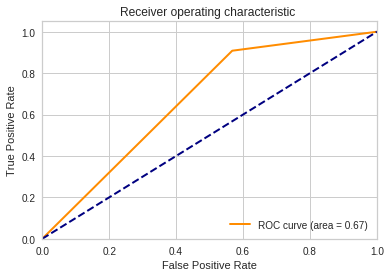

In [71]:
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(y_pred)    

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute weighted-average ROC curve and ROC area
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

# Regression

In [45]:
cv = CountVectorizer(max_features = 2000)
x = cv.fit_transform(cleaned_train_phrases).toarray()
y = train_data.iloc[:, 2].values

lr = linear_model.LinearRegression()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

lr.fit(x_train, y_train)

filename = 'lr_model.sav'
pickle.dump(lr, open(filename, 'wb'))

test_score = lr.score(x_test, y_test)
print("Accuracy : ", test_score)

Accuracy :  0.330695728586


# Loading Model and predicting results

In [46]:
loaded_model = pickle.load(open('lr_model.sav', 'rb'))

cv = CountVectorizer(max_features = 2000)
docs = cv.fit_transform(cleaned_train_phrases).toarray()
labels = train_data.iloc[:, 2].values

result = loaded_model.predict(docs)

a_sentiment = ["" for x in range(np.shape(result)[0])]
p_sentiment = ["" for x in range(np.shape(result)[0])]

for i in range(np.shape(result)[0]):
    if labels[i] == 0:
        a_sentiment[i] = "negtive"
    if labels[i] == 1:
        a_sentiment[i] = "somewhat negtive"
    if labels[i] == 2:
        a_sentiment[i] = "neutral"    
    if labels[i] == 3:
        a_sentiment[i] = "somewhat positive"
    if labels[i] == 4:
        a_sentiment[i] = "positive" 

for i in range(np.shape(result)[0]):
    if result[i] == 0:
        p_sentiment[i] = "negtive"
    if result[i] == 1:
        p_sentiment[i] = "somewhat negtive"
    if result[i] == 2:
        p_sentiment[i] = "neutral"    
    if result[i] == 3:
        p_sentiment[i] = "somewhat positive"
    if result[i] == 4:
        p_sentiment[i] = "positive" 
        
print (train_data['Cleaned_Phrase'][-55:-50])
print (p_sentiment[-55:-50])
print (a_sentiment[-55:-50])

156005                                    capable clayburgh
156006                                    capable clayburgh
156007    really great job anchoring character emotional...
156008    great job anchoring character emotional realit...
156009    great job anchoring character emotional realit...
Name: Cleaned_Phrase, dtype: object
['', '', '', '', '']
['somewhat positive', 'somewhat negtive', 'positive', 'somewhat positive', 'somewhat positive']


# Balanced Accuracy Rate

In [17]:
test_pred = lr.predict(x_test)
test_pred = np.floor(test_pred)
x = cv.fit_transform(cleaned_train_phrases).toarray()
y = train_data.iloc[:, 2].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

print ("BAC : ",balanced_accuracy_score(y_test, test_pred))

BAC :  0.310899616482


# Area Under the Receiver Operating Characteristic Curve

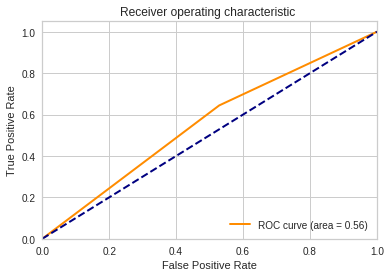

In [18]:
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(test_pred)    

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute weighted-average ROC curve and ROC area
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

# Artificial Neural Network

In [83]:
np.random.seed(0)

if __name__ == "__main__":

    #load data
    train_df = pd.read_csv('train.tsv', sep='\t', header=0)
    

    raw_docs_train = train_df['Phrase'].values
    
    sentiment_train = train_df['Sentiment'].values
    num_labels = len(np.unique(sentiment_train))

    #text pre-processing
    stop_words = set(stopwords.words('english'))
    stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
    stemmer = SnowballStemmer('english')

    print ("pre-processing train docs...")
    processed_docs_train = []
    for doc in raw_docs_train:
       tokens = word_tokenize(doc)
       filtered = [word for word in tokens if word not in stop_words]
       stemmed = [stemmer.stem(word) for word in filtered]
       processed_docs_train.append(stemmed)
   
    

    processed_docs_all = processed_docs_train

    dictionary = corpora.Dictionary(processed_docs_all)
    dictionary_size = len(dictionary.keys())
    print ("dictionary size: ", dictionary_size) 
    #dictionary.save('dictionary.dict')
    #corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    print ("converting to token ids...")
    word_id_train, word_id_len = [], []
    for doc in processed_docs_train:
        word_ids = [dictionary.token2id[word] for word in doc]
        word_id_train.append(word_ids)
        word_id_len.append(len(word_ids))

    
    
    seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

    #pad sequences
    word_id_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
   
    y_train_enc = np_utils.to_categorical(sentiment_train, num_labels)

    #LSTM
    print ("fitting Neural Network ...")
    model = Sequential()
    model.add(Embedding(dictionary_size,32, input_length=seq_len))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(250, activation='relu'))
    model.add(Dense(5, activation='sigmoid'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    x_train, x_test, y_train, y_test = train_test_split(word_id_train, y_train_enc, test_size = 0.30, random_state = 0)
    
    model.fit(x_train, y_train, nb_epoch=20, batch_size=512, verbose=1)
    
    model.save("nn_model.h5")

    test_pred = model.predict_classes(x_test)

    loss, accuracy = model.evaluate(x_test, y_test, batch_size=512, verbose=0)
    
    print ("Accuracy : ",accuracy)
    

pre-processing train docs...
dictionary size:  11852
converting to token ids...
fitting Neural Network ...
Epoch 1/20
109242/109242 [==============================] - 3s 26us/step - loss: 1.3594 - acc: 0.5175
Epoch 2/20
109242/109242 [==============================] - 2s 19us/step - loss: 1.2385 - acc: 0.6120
Epoch 3/20
109242/109242 [==============================] - 2s 19us/step - loss: 1.1944 - acc: 0.6484
Epoch 4/20
109242/109242 [==============================] - 2s 18us/step - loss: 1.1724 - acc: 0.6620
Epoch 5/20
109242/109242 [==============================] - 2s 17us/step - loss: 1.1582 - acc: 0.6713
Epoch 6/20
109242/109242 [==============================] - 2s 18us/step - loss: 1.1481 - acc: 0.6775
Epoch 7/20
109242/109242 [==============================] - 2s 17us/step - loss: 1.1411 - acc: 0.6828
Epoch 8/20
109242/109242 [==============================] - 2s 20us/step - loss: 1.1340 - acc: 0.6864
Epoch 9/20
109242/109242 [==============================] - 3s 29us/step - lo

# Loading Model and predicting results

In [33]:
model = Sequential()
model.add(Embedding(dictionary_size,32, input_length=seq_len))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cv = CountVectorizer(max_features = 2000)
docs = cv.fit_transform(cleaned_train_phrases).toarray()
labels = train_data.iloc[:, 2].values

model.load_weights("nn_model.h5")


result = model.predict(word_id_train)

a_sentiment = ["" for x in range(np.shape(result)[0])]
p_sentiment = ["" for x in range(np.shape(result)[0])]

for i in range(np.shape(result)[0]):
    if labels[i] == 0:
        a_sentiment[i] = "negtive"
    if labels[i] == 1:
        a_sentiment[i] = "somewhat negtive"
    if labels[i] == 2:
        a_sentiment[i] = "neutral"    
    if labels[i] == 3:
        a_sentiment[i] = "somewhat positive"
    if labels[i] == 4:
        a_sentiment[i] = "positive" 

for i in range(np.shape(result)[0]):
    if np.argmax(result[i]) == 0:
        p_sentiment[i] = "negtive"
    if np.argmax(result[i]) == 1:
        p_sentiment[i] = "somewhat negtive"
    if np.argmax(result[i]) == 2:
        p_sentiment[i] = "neutral"    
    if np.argmax(result[i]) == 3:
        p_sentiment[i] = "somewhat positive"
    if np.argmax(result[i]) == 4:
        p_sentiment[i] = "positive" 
        
print (train_data['Cleaned_Phrase'][-55:-50])
print (p_sentiment[-55:-50])
print (a_sentiment[-55:-50])

156005                                    capable clayburgh
156006                                    capable clayburgh
156007    really great job anchoring character emotional...
156008    great job anchoring character emotional realit...
156009    great job anchoring character emotional realit...
Name: Cleaned_Phrase, dtype: object
['neutral', 'neutral', 'somewhat positive', 'somewhat positive', 'somewhat positive']
['somewhat positive', 'somewhat negtive', 'positive', 'somewhat positive', 'somewhat positive']


# Balanced Accuracy Rate

In [42]:
x = cv.fit_transform(cleaned_train_phrases).toarray()
y = train_data.iloc[:, 2].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

print ("BAC : ",balanced_accuracy_score(y_test,test_pred))

BAC :  0.407495963758


# Area Under the Receiver Operating Characteristic Curve

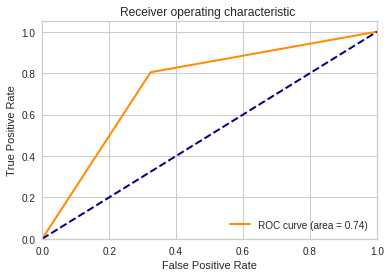

In [43]:
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(test_pred)    

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute weighted-average ROC curve and ROC area
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

# LSTM

In [48]:
np.random.seed(0)

if __name__ == "__main__":

    #load data
    train_df = pd.read_csv('train.tsv', sep='\t', header=0)
    

    raw_docs_train = train_df['Phrase'].values
    
    sentiment_train = train_df['Sentiment'].values
    num_labels = len(np.unique(sentiment_train))

    #text pre-processing
    stop_words = set(stopwords.words('english'))
    stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
    stemmer = SnowballStemmer('english')

    print ("pre-processing train docs...")
    processed_docs_train = []
    for doc in raw_docs_train:
       tokens = word_tokenize(doc)
       filtered = [word for word in tokens if word not in stop_words]
       stemmed = [stemmer.stem(word) for word in filtered]
       processed_docs_train.append(stemmed)
   
    

    processed_docs_all = processed_docs_train

    dictionary = corpora.Dictionary(processed_docs_all)
    dictionary_size = len(dictionary.keys())
    print ("dictionary size: ", dictionary_size) 
    #dictionary.save('dictionary.dict')
    #corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    print ("converting to token ids...")
    word_id_train, word_id_len = [], []
    for doc in processed_docs_train:
        word_ids = [dictionary.token2id[word] for word in doc]
        word_id_train.append(word_ids)
        word_id_len.append(len(word_ids))

    
    
    seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

    #pad sequences
    word_id_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
   
    y_train_enc = np_utils.to_categorical(sentiment_train, num_labels)

    #LSTM
    print ("fitting LSTM ...")
    model = Sequential()
    model.add(Embedding(dictionary_size, 128))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    x_train, x_test, y_train, y_test = train_test_split(word_id_train, y_train_enc, test_size = 0.30, random_state = 0)
    
    model.fit(x_train, y_train, nb_epoch=10, batch_size=512, verbose=1)
    
    model.save_weights("lstm_model.h5")

    test_pred = model.predict_classes(x_test)

    loss, accuracy = model.evaluate(x_test, y_test, batch_size=512, verbose=0)
    
    print ("Accuracy : ",accuracy)
    

pre-processing train docs...
dictionary size:  11852
converting to token ids...
fitting LSTM ...
Epoch 1/10
109242/109242 [==============================] - 8s 74us/step - loss: 1.1196 - acc: 0.5552
Epoch 2/10
109242/109242 [==============================] - 7s 68us/step - loss: 0.8691 - acc: 0.6458
Epoch 3/10
109242/109242 [==============================] - 7s 64us/step - loss: 0.8056 - acc: 0.6699
Epoch 4/10
109242/109242 [==============================] - 8s 72us/step - loss: 0.7658 - acc: 0.6844
Epoch 5/10
109242/109242 [==============================] - 7s 67us/step - loss: 0.7380 - acc: 0.6936
Epoch 6/10
109242/109242 [==============================] - 7s 67us/step - loss: 0.7135 - acc: 0.7014: 0s - loss: 0.7106 
Epoch 7/10
109242/109242 [==============================] - 7s 67us/step - loss: 0.6919 - acc: 0.7087
Epoch 8/10
109242/109242 [==============================] - 7s 66us/step - loss: 0.6738 - acc: 0.7154
Epoch 9/10
109242/109242 [==============================] - 7s 64us

# Loading Model and predicting results

In [59]:
model = Sequential()
model.add(Embedding(dictionary_size, 128))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cv = CountVectorizer(max_features = 2000)
docs = cv.fit_transform(cleaned_train_phrases).toarray()
labels = train_data.iloc[:, 2].values

model.load_weights("lstm_model.h5")


result = model.predict(word_id_train)

a_sentiment = ["" for x in range(np.shape(result)[0])]
p_sentiment = ["" for x in range(np.shape(result)[0])]

for i in range(np.shape(result)[0]):
    if labels[i] == 0:
        a_sentiment[i] = "negtive"
    if labels[i] == 1:
        a_sentiment[i] = "somewhat negtive"
    if labels[i] == 2:
        a_sentiment[i] = "neutral"    
    if labels[i] == 3:
        a_sentiment[i] = "somewhat positive"
    if labels[i] == 4:
        a_sentiment[i] = "positive" 

for i in range(np.shape(result)[0]):
    if np.argmax(result[i]) == 0:
        p_sentiment[i] = "negtive"
    if np.argmax(result[i]) == 1:
        p_sentiment[i] = "somewhat negtive"
    if np.argmax(result[i]) == 2:
        p_sentiment[i] = "neutral"    
    if np.argmax(result[i]) == 3:
        p_sentiment[i] = "somewhat positive"
    if np.argmax(result[i]) == 4:
        p_sentiment[i] = "positive" 
        
print (train_data['Cleaned_Phrase'][-55:-50])
print (p_sentiment[-55:-50])
print (a_sentiment[-55:-50])

156005                                    capable clayburgh
156006                                    capable clayburgh
156007    really great job anchoring character emotional...
156008    great job anchoring character emotional realit...
156009    great job anchoring character emotional realit...
Name: Cleaned_Phrase, dtype: object
['neutral', 'neutral', 'positive', 'somewhat positive', 'somewhat positive']
['somewhat positive', 'somewhat negtive', 'positive', 'somewhat positive', 'somewhat positive']


# Balanced Accuracy Rate

In [81]:
x = cv.fit_transform(cleaned_train_phrases).toarray()
y = train_data.iloc[:, 2].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.30, random_state = 0)

print ("BAC : ",balanced_accuracy_score(y_test, test_pred))

BAC :  0.528015610757


# Area Under the Receiver Operating Characteristic Curve

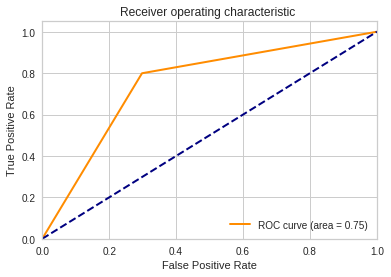

In [82]:
lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test)
y_pred = lb.transform(test_pred)    

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute weighted-average ROC curve and ROC area
fpr["weighted"], tpr["weighted"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["weighted"] = auc(fpr["weighted"], tpr["weighted"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ')
plt.legend(loc="lower right")
plt.show()

# Just For Demo

In [33]:
np.random.seed(0)

if __name__ == "__main__":

    #load data
    train_df = pd.read_csv('train.tsv', sep='\t', header=0)
    

    raw_docs_train = train_df['Phrase'].values
    
    #raw_docs_train = ['I loved the movie']
    
    #text pre-processing
    stop_words = set(stopwords.words('english'))
    stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
    stemmer = SnowballStemmer('english')

    print ("pre-processing train docs...")
    processed_docs_train = []
    for doc in raw_docs_train:
       tokens = word_tokenize(doc)
       filtered = [word for word in tokens if word not in stop_words]
       stemmed = [stemmer.stem(word) for word in filtered]
       processed_docs_train.append(stemmed)
   
    

    processed_docs_all = processed_docs_train

    dictionary = corpora.Dictionary(processed_docs_all)
    dictionary_size = len(dictionary.keys())
    print ("dictionary size: ", dictionary_size) 
    #dictionary.save('dictionary.dict')
    #corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

    print ("converting to token ids...")
    word_id_train, word_id_len = [], []
    for doc in processed_docs_train:
        word_ids = [dictionary.token2id[word] for word in doc]
        word_id_train.append(word_ids)
        word_id_len.append(len(word_ids))

    
    
    seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

    #pad sequences
    word_id_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
    
    model = Sequential()
    model.add(Embedding(dictionary_size, 128))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.load_weights("lstm_model.h5")


pre-processing train docs...
dictionary size:  11852
converting to token ids...


In [35]:
raw_docs_train = ['I loved the movie','It was a great movie', 'I watched it','It was a bad movie','It was a tough movie to digest']
    
#text pre-processing
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])
stemmer = SnowballStemmer('english')

print ("pre-processing train docs...")
processed_docs_train = []
for doc in raw_docs_train:
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    stemmed = [stemmer.stem(word) for word in filtered]
    processed_docs_train.append(stemmed)
   
    

processed_docs_all = processed_docs_train

dictionary = corpora.Dictionary(processed_docs_all)
dictionary_size = len(dictionary.keys())
print ("dictionary size: ", dictionary_size) 
    #dictionary.save('dictionary.dict')
    #corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print ("converting to token ids...")
word_id_train, word_id_len = [], []
for doc in processed_docs_train:
    word_ids = [dictionary.token2id[word] for word in doc]
    word_id_train.append(word_ids)
    word_id_len.append(len(word_ids))

    
    
seq_len = np.round((np.mean(word_id_len) + 2*np.std(word_id_len))).astype(int)

#pad sequences
word_id_train = sequence.pad_sequences(np.array(word_id_train), maxlen=seq_len)
    

result = model.predict(word_id_train)


p_sentiment = ["" for x in range(np.shape(result)[0])]



for i in range(np.shape(result)[0]):
    if np.argmax(result[i]) == 0:
        p_sentiment[i] = "negtive"
    if np.argmax(result[i]) == 1:
        p_sentiment[i] = "somewhat negtive"
    if np.argmax(result[i]) == 2:
        p_sentiment[i] = "neutral"    
    if np.argmax(result[i]) == 3:
        p_sentiment[i] = "somewhat positive"
    if np.argmax(result[i]) == 4:
        p_sentiment[i] = "positive" 
        

print (p_sentiment)

pre-processing train docs...
dictionary size:  9
converting to token ids...
['neutral', 'somewhat positive', 'neutral', 'positive', 'somewhat positive']
